In [1]:
from libs.Dataset import *
import matplotlib.pyplot as plt
import dill # allow to save notebook session, useful for test https://towardsdatascience.com/how-to-restore-your-jupyter-notebook-session-dfeadbd86d65

### Test Single Trashbin Pytorch Lighting DataModule

In [2]:
# Init our data pipeline
dm = TrashbinDataModule(data_dir= "dataset/")
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup()

Do nothing...


/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


In [3]:
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
print("Required shape: val_imgs: {} val_shapes: {}".format(val_imgs.shape, val_labels.shape))

Required shape: val_imgs: torch.Size([32, 3, 28, 28]) val_shapes: torch.Size([32])


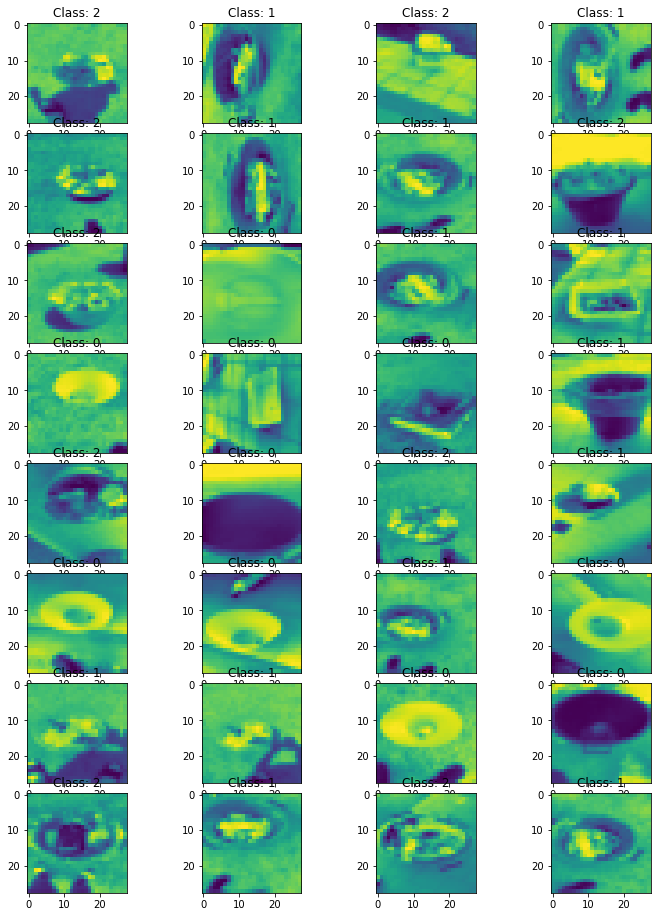

In [4]:
images, labels = iter(dm.train_dataloader()).next()
plt.figure(figsize = (12,16))
for e,(img, lbl) in enumerate(zip(images, labels)):
    plt.subplot(8,4,e+1)
    plt.imshow(img[0])
    plt.title(f'Class: {lbl.item()}')

plt.subplots_adjust(hspace=0.1)

### Test Triplet Trashbin Pytorch Lighting Data Module

In [2]:
# Init our data pipeline
dm = TripletTrashbinDataModule(data_dir= "dataset/")
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup()

Do nothing on prepare_data


/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


In [3]:
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
print("Required shape: val_imgs: {} val_shapes: {}".format(val_imgs.shape, val_labels.shape))

Required shape: val_imgs: torch.Size([32, 3, 28, 28]) val_shapes: torch.Size([32, 3, 28, 28])


Print Train Dataset with matplotlib

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

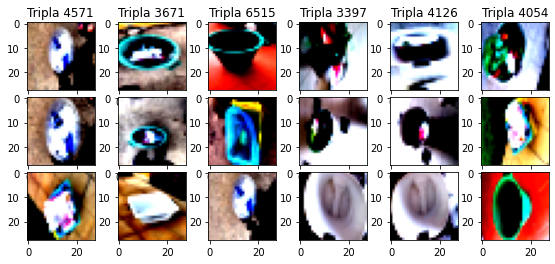

In [4]:
plt.figure(figsize=(16,4))
for i, idx in enumerate(np.random.choice(len(dm.trb_train), 6)):
    ax = plt.subplot(3,10,i+1)
    ax.set_title('Tripla {}'.format(idx))
    
    plt.imshow(dm.trb_train[i][0].T)
    plt.subplot(3,10,i+11)
    # plt.title('Class: {}'.format(dm.trb_train[i][3]))
    plt.imshow(dm.trb_train[i][1].T)
    # plt.title('Class: {}'.format(dm.trb_train[i][4]))
    plt.subplot(3,10,i+21)
    plt.imshow(dm.trb_train[i][2].T)
    # plt.title('Class: {}'.format(dm.trb_train[i][5]))

plt.subplots_adjust(hspace=0.1)
plt.show()

In [5]:
dill.dump_session('notebook_env_triplet_dl.db')

### Test model

In [ ]:
dill.load_session('notebook_env.db')

In [ ]:
# TODO: Modello custom